In [1]:
library(patchwork)
library(tidymodels)

library(tidyverse)
library(repr)
library(infer)
library(lubridate)

options(repr.matrix.max.rows = 6)
library(dplyr)


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ recipes      1.1.0
✔ dials        1.3.0     ✔ rsample      1.2.1
✔ dplyr        1.1.4     ✔ tibble       3.2.1
✔ ggplot2      3.5.1     ✔ tidyr        1.3.1
✔ infer        1.0.7     ✔ tune         1.1.2
✔ modeldata    1.4.0     ✔ workflows    1.1.4
✔ parsnip      1.2.1     ✔ workflowsets 1.0.1
✔ purrr        1.0.2     ✔ yardstick    1.3.1

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Learn how to get started at https://www.tidymodels.org/start/

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     ✔ stringr   1.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──


## Merge dataframe

In [2]:
set.seed(1)
setwd("/home/jovyan/work/Minecraft-DSCI100-Project/R code")
players <- read_csv("data/players.csv")
unclean_sessions <- read_csv("data/sessions.csv")

merged_df <- left_join(unclean_sessions, players, by = "hashedEmail")


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## What does the data look like?

In [3]:
set.seed(1)
gender_play_time <- merged_df |> group_by(gender) |> summarize(avg_hours = mean(played_hours))
print(gender_play_time)
#Notice, male, female, and non-binary make up a large majority of the player base. 
# For that reason they will be the only predictors
final_df <- merged_df |>   filter(gender %in% c("Female", "Male", "Non-binary")) |> mutate(subscribe = as_factor(subscribe))


# A tibble: 7 × 2
  gender            avg_hours
  <chr>                 <dbl>
1 Agender              12.5  
2 Female              136.   
3 Male                 77.4  
4 Non-binary          199.   
5 Other                 0.2  
6 Prefer not to say     1.34 
7 Two-Spirited          0.125


In [4]:
# PLAYER TYPE
expert_player <- filter(final_df, experience %in% c("Veteran", "Pro")) 
noob_player <- filter(final_df, experience %in% c("Beginner", "Amateur", "Regular"))

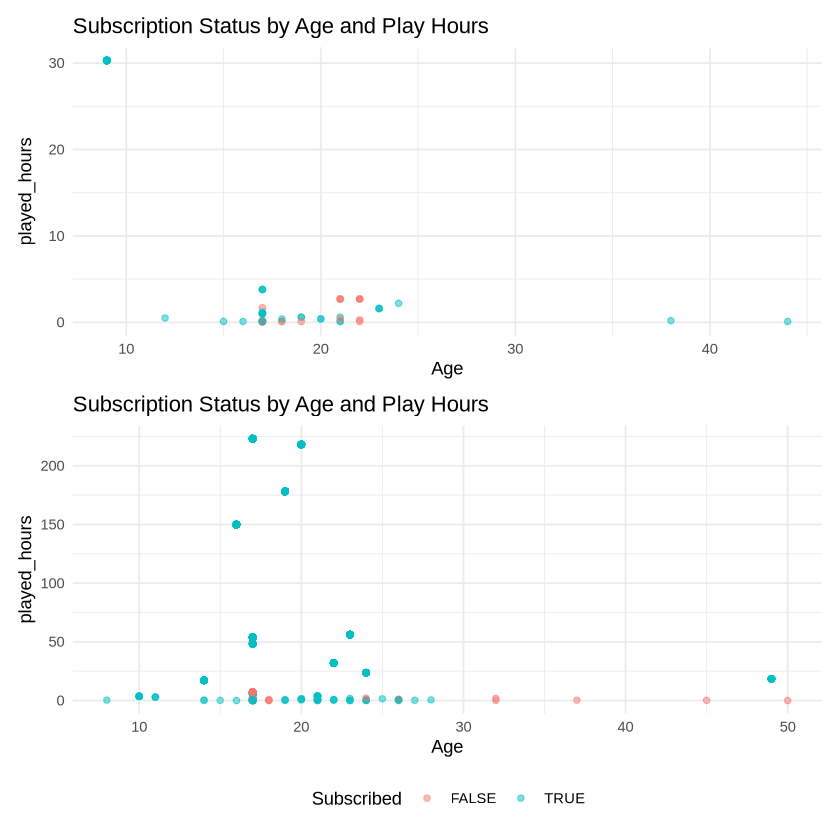

In [5]:
set.seed(1)

pro_plot <- expert_player |> 
  ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.5) +
  labs(title = "Subscription Status by Age and Play Hours", color = "Subscribed") +
  theme_minimal()
noob_plot <- noob_player |> 
  ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.5) +
  labs(title = "Subscription Status by Age and Play Hours", color = "Subscribed") +
  theme_minimal()

num_obs <- nrow(final_df)
summary <- final_df |> 
            group_by(subscribe) |>
            summarize(count = n(), percentage = n() / num_obs *100)
(pro_plot / noob_plot ) +
  plot_layout(guides = "collect") & theme(legend.position = "bottom")

# Prep for K-NN Classification

In [14]:
set.seed(1)

pro_train <- expert_player |> select(subscribe, Age, played_hours)
noob_train <- noob_player |> select(subscribe, Age, played_hours)

# PRO
pro_split <- initial_split(pro_train, prop = 0.75, strata = subscribe)
pro_train <- training(pro_split)
pro_test <- testing(pro_split)
# NOOB
noob_split <- initial_split(noob_train, prop = 0.75, strata = subscribe)
noob_train <- training(noob_split)
noob_test <- testing(noob_split)

pro_prop <- pro_train |>
            group_by(subscribe) |>
            summarize(n = n()) |>
            mutate(percent = 100* n/nrow(pro_train))

noob_prop <- noob_train |>
            group_by(subscribe) |>
            summarize(n = n()) |>
            mutate(percent = 100* n/nrow(noob_train))
cat("Pro Subscription Rate")
pro_prop 
cat("New Player Subscription Rate")
noob_prop

pro_recipe <- recipe(subscribe ~., data = pro_train) |>
            step_scale(all_predictors())|>
            step_center(all_predictors())
noob_recipe <- recipe(subscribe ~., data = noob_train) |>
            step_scale(all_predictors())|>
            step_center(all_predictors())

knn_spec_new <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
            set_engine("kknn") |>
            set_mode("classification")
knn_spec_pro <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) |>
            set_engine("kknn") |>
            set_mode("classification")

pro_fit <- workflow() |>
            add_recipe(pro_recipe) |>
            add_model(knn_spec_pro) |>
            fit(data = pro_train)
noob_fit <- workflow() |>
            add_recipe(noob_recipe) |>
            add_model(knn_spec_new) |>
            fit(data = noob_train)

pro_test_predict <- predict(pro_fit, pro_test) |>
                    bind_cols(pro_test)
noob_test_predict <- predict(noob_fit, noob_test) |>
                    bind_cols(noob_test)

pro_accuracy <- pro_test_predict |> 
            metrics(truth = subscribe, estimate = .pred_class) |>
                    filter(.metric == "accuracy") |> pull()
noob_accuracy <- noob_test_predict |> 
            metrics(truth = subscribe, estimate = .pred_class) |>
                    filter(.metric == "accuracy") |> pull()





pro_recall <- pro_test_predict |> recall(truth = subscribe, estimate = .pred_class, event_level = "first") |> pull()
pro_precision <- pro_test_predict |> precision(truth = subscribe, estimate = .pred_class, event_level = "first") |> pull()
noob_recall <- noob_test_predict |> recall(truth = subscribe, estimate = .pred_class, event_level = "first") |> pull()
noob_precision <- noob_test_predict |> precision(truth = subscribe, estimate = .pred_class, event_level = "first") |> pull()
cat("PRO ACCURACY: ", pro_accuracy, "\n")
cat("PRO RECALL: ", pro_recall, "\n")
cat("PRO PRECISION: ", pro_precision, "\n")
cat("NEW PLAYER ACCURACY: ", noob_accuracy, "\n")
cat("NEW PLAYER RECALL: ", noob_recall, "\n")
cat("NEW PLAYER PRECISION: ", noob_precision)


Pro Subscription Rate

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,12,22.22222
TRUE,42,77.77778


New Player Subscription Rate

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,58,5.4155
TRUE,1013,94.5845


PRO ACCURACY:  0.9473684 
PRO RECALL:  0.75 
PRO PRECISION:  1 
NEW PLAYER ACCURACY:  0.9971989 
NEW PLAYER RECALL:  0.95 
NEW PLAYER PRECISION:  1

## TUNE: Pro Player Choose K

In [15]:
set.seed(1)

pro_fold <- vfold_cv(pro_train, v = 5, strata = subscribe)
noob_fold <- vfold_cv(noob_train, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 2)) 

## PRO CHOOSE K 
knn_spec <- nearest_neighbor(
    weight_func = "rectangular",
    neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_pro <- workflow() |>
  add_recipe(pro_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = pro_fold, grid = k_vals) |>
  collect_metrics()


pro_res <- knn_pro |>
  filter(.metric == "accuracy")

pro_plot <- pro_res |> ggplot(aes(x = neighbors, y = mean)) +
                        geom_point() +
                        geom_line() +
                        ggtitle("Pro Player: accuracy vs k")

## Tune: New Player Choose K

In [16]:
set.seed(1)

## NOOB CHOOSE K
knn_noob <- workflow() |>
  add_recipe(noob_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = noob_fold, grid = k_vals) |>
  collect_metrics()


noob_res <- knn_noob |>
  filter(.metric == "accuracy")

noob_plot <- noob_res |> ggplot(aes(x = neighbors, y = mean)) +
                        geom_point() +
                        geom_line() +
                        ggtitle("New Player: accuracy vs k")

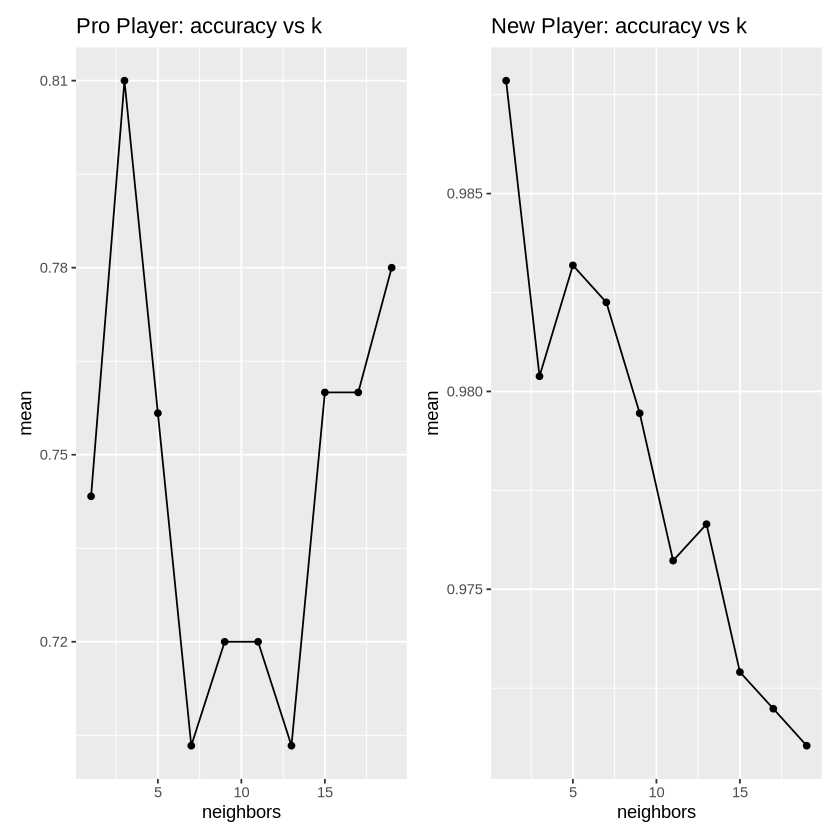

In [17]:
pro_plot+noob_plot

## How does our model perform
# New Players
- k = 2
- NEW PLAYER ACCURACY:  0.9971989 
- NEW PLAYER RECALL:  0.95 
- NEW PLAYER PRECISION:  1
# Pro Players
- k = 4
- PRO ACCURACY:  0.9473684 
- PRO RECALL:  0.75 
- PRO PRECISION:  1 




From these results we can see that it is easier to infer the newsletter subscription status from a population of newer players. 